# Pulse Height Analysis - Cluster Size Study

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// disable autoscroll

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

from scipy.optimize import curve_fit
import ROOT
import os, re, math
import matplotlib.pyplot as plt
import numpy as np


from matplotlib import animation
from IPython.display import HTML

Welcome to JupyROOT 6.09/01


## Some important subroutines follow
+import of the data

In [3]:
def load_root_files():

    file_name_list      = [ f for f in os.listdir("pulse_height_data") if os.path.isfile("pulse_height_data/" + f) and f[-5:]==".root"]

    fill_ID_and_Ch_and_ROC_and_hist_name_to_hist= {}

    for file_name in file_name_list:

        fill_ID             = int(re.findall(r'\d+', file_name)[0])
        fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID]= {}

        file_    = ROOT.TFile("pulse_height_data/" + file_name, "READ")

        list_of_objects     = sorted([RootKey.GetName() for RootKey in file_.GetListOfKeys()])
            
        for directory_name in list_of_objects:

            Ch, Roc = [int(_) for _ in re.findall(r'\d+', directory_name )]
            
            if file_.Get(directory_name + "/h_clusterSize").Integral()<10000:
                continue

            try:
                fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc]  = {}
            except:
                fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch]       = {}
                fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc]  = {}

            directory       = file_.Get(directory_name)
            list_of_hists   = [RootKey.GetName() for RootKey in directory.GetListOfKeys()]

            for hist_name in list_of_hists:
                if hist_name != "h_spatialChargeDistribution":
                    fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc][hist_name] = file_.Get(directory_name + "/" + hist_name).Clone()
                    fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc][hist_name].SetDirectory(0)  
                    
        file_.Close()
        
    return fill_ID_and_Ch_and_ROC_and_hist_name_to_hist

In [4]:
def fittie(X, Y,k):

    if len(X)!=len(Y):
        print "Error"
        return [[],[]]
    else:
        retX = []
        retY = []
        for i1 in range(0,len(X)-k):
            sX = []
            sY = []
            for i2 in range(k):
                sX+=[X[i1+i2]]
                sY+=[Y[i1+i2]]
            
            z = np.polyfit(sX, sY, 1)
            
            retX += [X[i1]]
            retY += [z[0]]
            
        return [retX,retY]
    
def median_filter(v,k):
    ret_v = v[:]
    
    for i in range(k, len(v)-k):
        ret_v[i] = np.median(v[i-k:i+k])  
    
    
    return ret_v
        
    
def x_values_of_points_at_p_percent_of_max_on_the_two_sides_of_max(v, p):
    
    maximum = max(v)
    if sum([ 1.0 for v_ in v if v_ == maximum])!=1.0:
        return [-1,-1]
    else:
        maximum_location = v.index(maximum)
        left = v[:maximum_location]
        right= v[maximum_location:]
        
        left_D = [abs(maximum*p-x) for x in left]
        right_D= [abs(maximum*p-x) for x in right]
        
        i1 = left_D.index(min(left_D))
        i2 = right_D.index(min(right_D)) + len(left_D)
        
        return [i1, i2]
            
            
def gaussian(x,a,m,sigma):
    return a*np.exp(-(x-m)**2/(2*sigma**2))/sigma

In [5]:
"""
Load histograms only once
"""
hist_dict = load_root_files()

# Plotting Some Properties of the Cluster Size Distribution

## The ratio of the numerosity of different cluster sizes (2/1 and 3/1)

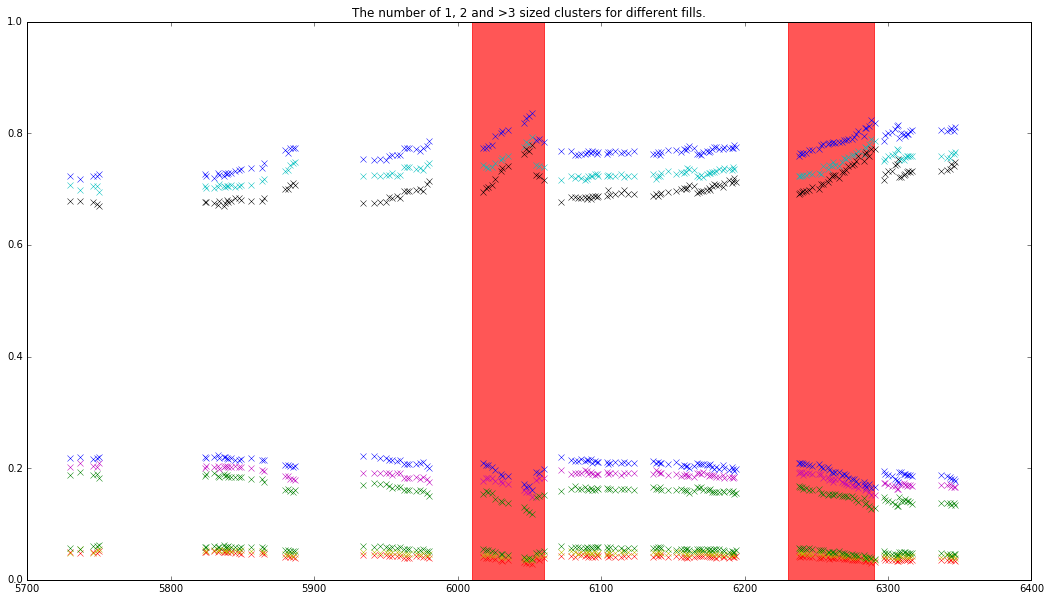

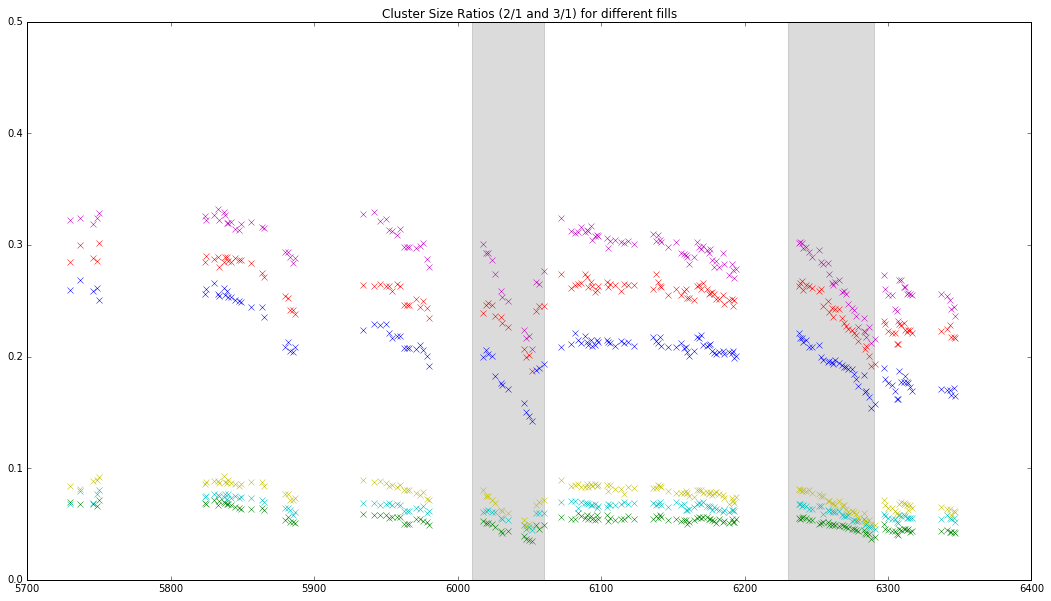

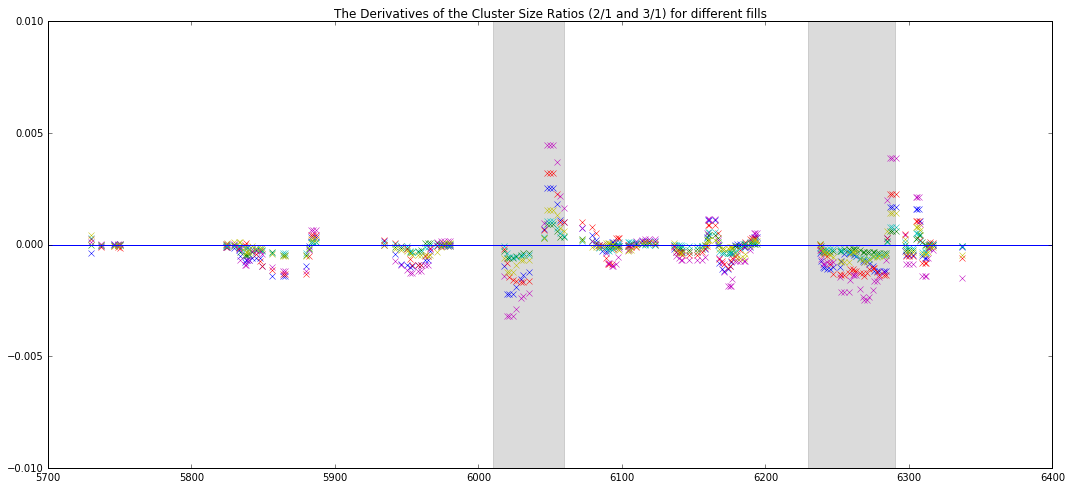

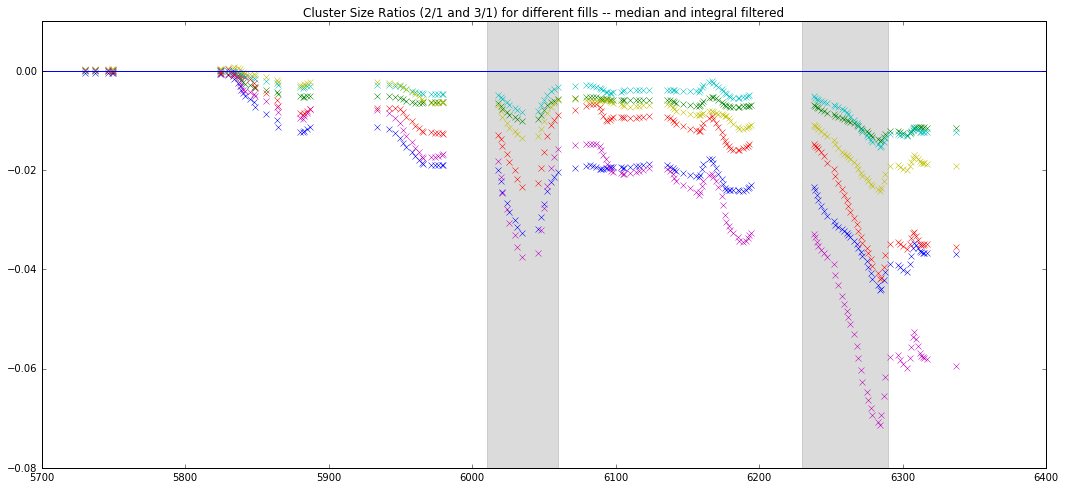

[2, 0] has been plotted using 160 points
[2, 1] has been plotted using 159 points
[2, 2] has been plotted using 160 points


In [6]:
"""
Plot the percentage of different claster sizes (1,2,3) as a function of fill ID
for a few Ch - Roc pairs
"""

Ch_Roc_pairs = [[2, 0], [2, 1], [2, 2],] 


n_plot_to_fill_IDs                  = []
n_plot_to_N_single_pixel_clusters   = []
n_plot_to_N_double_pixel_clusters   = []
n_plot_to_N_triple_pixel_clusters   = []
n_plot_to_N_integral                = []


for pair in Ch_Roc_pairs:

    n_plot_to_fill_IDs                += [[]]
    n_plot_to_N_single_pixel_clusters += [[]]
    n_plot_to_N_double_pixel_clusters += [[]]
    n_plot_to_N_triple_pixel_clusters += [[]]
    n_plot_to_N_integral              += [[]]

    fill_IDs = sorted(hist_dict.keys())
    for fill_ID in fill_IDs:
        if pair[0] in hist_dict[fill_ID].keys():
            if pair[1] in hist_dict[fill_ID][pair[0]].keys():
                n_plot_to_fill_IDs[-1] += [fill_ID]

                hist = hist_dict[fill_ID][pair[0]][pair[1]]["h_clusterSize"].Clone()
                
                integral = hist.Integral()
                
                if integral!=0:
                    n_plot_to_N_integral[-1]              += [integral]
                    n_plot_to_N_single_pixel_clusters[-1] += [hist.GetBinContent(2)/integral]
                    n_plot_to_N_double_pixel_clusters[-1] += [hist.GetBinContent(3)/integral]
                    n_plot_to_N_triple_pixel_clusters[-1] += [hist.GetBinContent(4)/integral]
                else:
                    n_plot_to_N_integral[-1]              += [0]
                    n_plot_to_N_single_pixel_clusters[-1] += [0]
                    n_plot_to_N_double_pixel_clusters[-1] += [0]
                    n_plot_to_N_triple_pixel_clusters[-1] += [0]
                
plt.figure(1,figsize=(18, 10))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    print pair, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    #fig, ax = plt.subplots()
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_N_single_pixel_clusters[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_1" )
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_N_double_pixel_clusters[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_2" )
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_N_triple_pixel_clusters[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_3" )

    plt.axvspan(6010, 6060, alpha=0.3, color='red')
    plt.axvspan(6230, 6290, alpha=0.3, color='red')
    
    
    plt.title("The number of 1, 2 and >3 sized clusters for different fills.")
    
    plt.ylim( 0,1.0 ) 
    
plt.figure(2,figsize=(18, 10))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    ratio_two_p_one = []
    ratio_thr_p_one = []
    for j in range(len(n_plot_to_N_single_pixel_clusters[i])):
        try:
            ratio_two_p_one += [n_plot_to_N_double_pixel_clusters[i][j]/n_plot_to_N_single_pixel_clusters[i][j]]
            ratio_thr_p_one += [n_plot_to_N_triple_pixel_clusters[i][j]/n_plot_to_N_single_pixel_clusters[i][j]]
        except: 
            ratio_two_p_one += [0]
            ratio_thr_p_one += [0]
    
    plt.plot(n_plot_to_fill_IDs[i], ratio_two_p_one,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_2/1" )
    plt.plot(n_plot_to_fill_IDs[i], ratio_thr_p_one,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_3/1" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("Cluster Size Ratios (2/1 and 3/1) for different fills")
    
    plt.ylim( 0, .5 ) 
    
#create a derivative of the ratios
plt.figure(3, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):
    
    pair = Ch_Roc_pairs[i]
    
    ratio_two_p_one = []
    ratio_thr_p_one = []
    for j in range(len(n_plot_to_N_single_pixel_clusters[i])):
        try:
            ratio_two_p_one += [n_plot_to_N_double_pixel_clusters[i][j]/n_plot_to_N_single_pixel_clusters[i][j]]
            ratio_thr_p_one += [n_plot_to_N_triple_pixel_clusters[i][j]/n_plot_to_N_single_pixel_clusters[i][j]]
        except: 
            ratio_two_p_one += [0]
            ratio_thr_p_one += [0]

    
    Dx,Dy2 = fittie(n_plot_to_fill_IDs[i], ratio_two_p_one,5)
    Dx,Dy3 = fittie(n_plot_to_fill_IDs[i], ratio_thr_p_one,5)
        
    plt.plot(Dx,median_filter(Dy2,3),"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_2/1D" )
    plt.plot(Dx,median_filter(Dy3,3),"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_3/1D" )
    
    
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.title("The Derivatives of the Cluster Size Ratios (2/1 and 3/1) for different fills")
    
    plt.axhline(0)

    plt.ylim(-0.01,.01)
    
plt.figure(4, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):
    
    pair = Ch_Roc_pairs[i]
    
    ratio_two_p_one = []
    ratio_thr_p_one = []
    for j in range(len(n_plot_to_N_single_pixel_clusters[i])):
        try:
            ratio_two_p_one += [n_plot_to_N_double_pixel_clusters[i][j]/n_plot_to_N_single_pixel_clusters[i][j]]
            ratio_thr_p_one += [n_plot_to_N_triple_pixel_clusters[i][j]/n_plot_to_N_single_pixel_clusters[i][j]]
        except: 
            ratio_two_p_one += [0]
            ratio_thr_p_one += [0]

    
    Dx,Dy2 = fittie(n_plot_to_fill_IDs[i], ratio_two_p_one,5)
    Dx,Dy3 = fittie(n_plot_to_fill_IDs[i], ratio_thr_p_one,5)
    
    Dy2 = median_filter(Dy2,3)
    Dy3 = median_filter(Dy3,3)
    
    for i in range(1,len(Dy2)):
        Dy2[i]+=Dy2[i-1]
        
    for i in range(1,len(Dy3)):
        Dy3[i]+=Dy3[i-1]
    
        
    plt.plot(Dx,Dy2,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_2/1D" )
    plt.plot(Dx,Dy3,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_3/1D" )
    
    
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.axhline(0)
    plt.title("Cluster Size Ratios (2/1 and 3/1) for different fills -- median and integral filtered")

    plt.ylim(-0.08,.01)

## The slope of the logarithm of the cluster size distibution

This was supposed to give similar result of the previous figures, as based on the animations, that the cluster size distribution is quite exponential. 

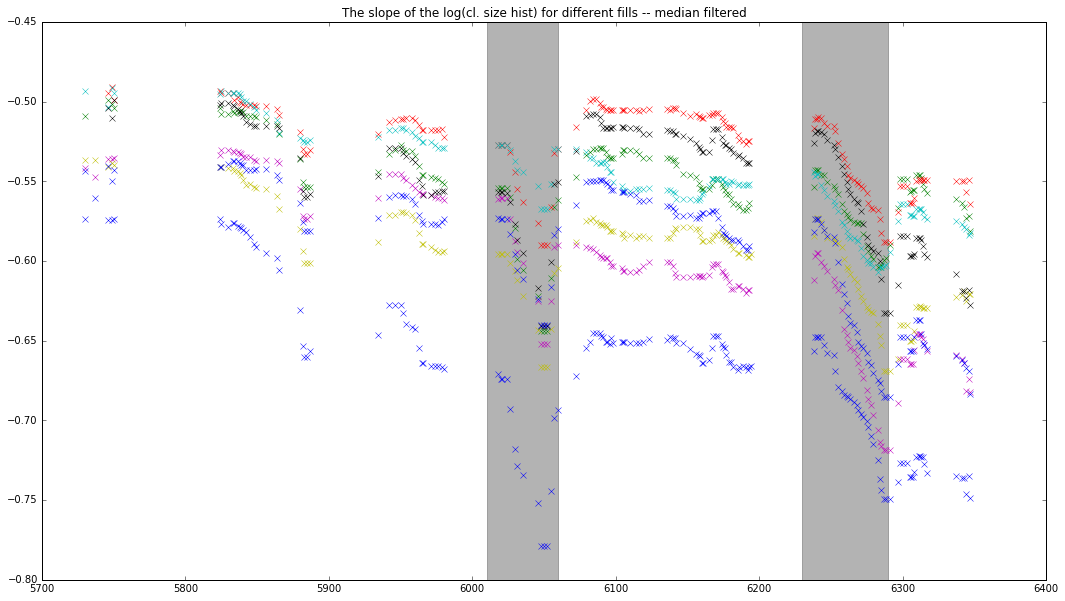

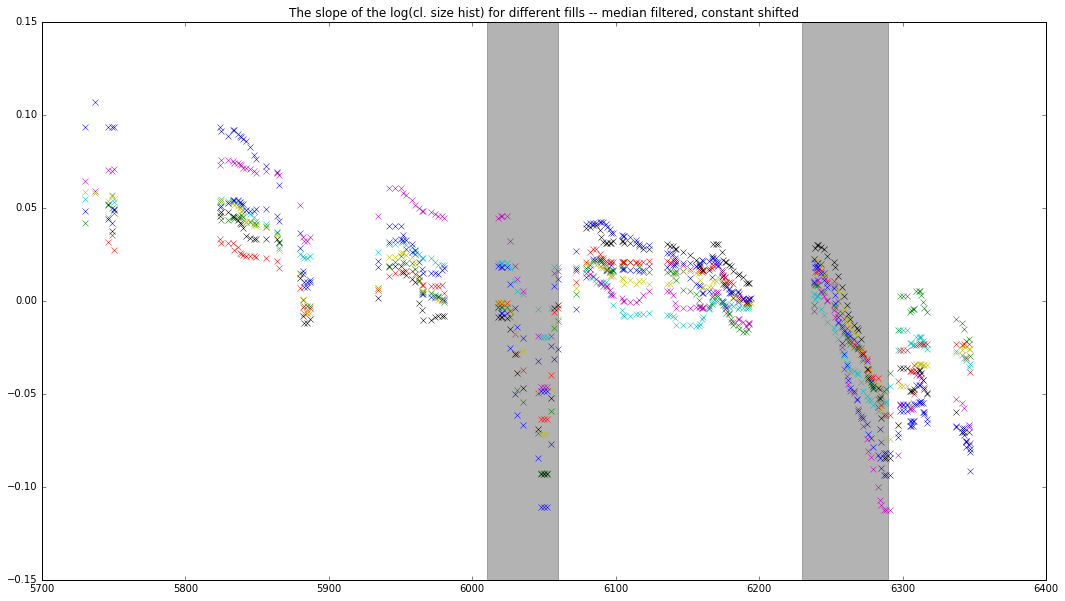

[2, 0] has been plotted using 160 points
[4, 0] has been plotted using 158 points
[5, 0] has been plotted using 157 points
[8, 0] has been plotted using 158 points
[10, 0] has been plotted using 159 points
[11, 0] has been plotted using 159 points
[13, 0] has been plotted using 157 points
[14, 0] has been plotted using 158 points
[2, 0] has been plotted using 160 points
[4, 0] has been plotted using 158 points
[5, 0] has been plotted using 157 points
[8, 0] has been plotted using 158 points
[10, 0] has been plotted using 159 points
[11, 0] has been plotted using 159 points
[13, 0] has been plotted using 157 points
[14, 0] has been plotted using 158 points


In [7]:
"""
Plot the slope of the line flitted on the log of the different claster sizes (1,2,3,4,5) as a function of fill ID
for a few Ch - Roc pairs
"""

Ch_Roc_pairs = [[2, 0], [2, 1], [2, 2],] 
Ch_Roc_pairs = [[4, 0], [4, 1], [4, 2],] 
Ch_Roc_pairs = [[8, 0], [8, 1], [8, 2],]
Ch_Roc_pairs = [[10, 0], [10, 1], [10, 2],] 
Ch_Roc_pairs = [[11, 0], [11, 1], [11, 2],]
Ch_Roc_pairs = [[2, 0], [4, 0], [5, 0], [8, 0], [10, 0], [11, 0], [13, 0], [14, 0],] 

n_plot_to_fill_IDs                  = []
n_plot_and_fill_ID_to_slope         = []


for pair in Ch_Roc_pairs:

    n_plot_to_fill_IDs                += [[]]
    n_plot_and_fill_ID_to_slope       += [[]]
    

    fill_IDs = sorted(hist_dict.keys())
    for fill_ID in fill_IDs:
        if pair[0] in hist_dict[fill_ID].keys():
            if pair[1] in hist_dict[fill_ID][pair[0]].keys():
                n_plot_to_fill_IDs[-1] += [fill_ID]

                hist = hist_dict[fill_ID][pair[0]][pair[1]]["h_clusterSize"].Clone()
                try:
                    hist.Scale(1.0/hist.Integral())
                except:
                    pass
                
                
                fit_list = []
                weight_list = []
                for i in range(2,7):
                    fit_list+= [np.log10(hist.GetBinContent(i))]
                    weight_list+=[hist.GetBinContent(i)]
                
                n_plot_and_fill_ID_to_slope[-1] += [np.polyfit(range(len(fit_list)), fit_list, 1, w=weight_list)[0]]
                
                
                
plt.figure(100,figsize=(18, 10))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    print pair, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    #fig, ax = plt.subplots()
    Dy = median_filter( n_plot_and_fill_ID_to_slope[i],3)
    plt.plot(n_plot_to_fill_IDs[i],  Dy,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_5slope" )
   
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.title("The slope of the log(cl. size hist) for different fills -- median filtered")
    
    #plt.ylim( 0,1.0 ) 
    
plt.figure(102,figsize=(18, 10))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    print pair, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    #fig, ax = plt.subplots()
    Dy = median_filter( n_plot_and_fill_ID_to_slope[i],3)
    plt.plot(n_plot_to_fill_IDs[i],  Dy-np.average(Dy),"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_5slope" )
   
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.title("The slope of the log(cl. size hist) for different fills -- median filtered, constant shifted")
    
    #plt.ylim( 0,1.0 ) 
    